### Normalizing the shape of shadow surfaces

Authors: Martin Hanik and Christoph von Tycowicz

This notebook accompanies the paper ‘‘Intrinsic shape analysis in archaeology: A case study on ancient sundials’’ and allows to replicate one of the experiments. In the following, we use geodesic regression in the shape space of differential coordinates to normalize the shape of Roman and Greek sundials with respect to the latitude of the installation site.

First, we import all necessary packages.

In [1]:
import jax.numpy as jnp
import numpy as np
import pyvista as pv
import os

from morphomatics.manifold.util import preshape, generalized_procrustes
from morphomatics.geom import Surface
from morphomatics.stats import RiemannianRegression, StatisticalShapeModel
from morphomatics.manifold import DifferentialCoords

Now, we load the triangle meshes of the shadow surfaces and provide the corresponding latitudes.

In [2]:
# download meshes
if not os.path.isdir('meshes'):
    from urllib.request import urlopen
    from zipfile import ZipFile

    zipurl = 'https://www.zib.de/ext-data/sundial_shadow_surfaces/meshes.zip'
    zipresp = urlopen(zipurl)
    tempzip = open('/tmp/tempfile.zip', 'wb')
    tempzip.write(zipresp.read())
    tempzip.close()
    zf = ZipFile('/tmp/tempfile.zip')
    zf.extractall(path = 'meshes/')
    zf.close()

# reference to construct the shape space
pyT = pv.read('./meshes/mean.ply')
v = jnp.array(pyT.points)
f = pyT.faces.reshape(-1, 4)[:, 1:]
ref = Surface(v, f)

directory_g = './meshes/Greece/'
# latitudes corresponding to shadow surfaces of sundials in directory
lat_g = jnp.array([37.3900, 37.3900, 36.091682])
# mapping latitudes to [0,1]
t_g = jnp.array([1., 1., 0.])

# Roman sundials
directory_r = './meshes/Roman/'
# latitudes corresponding to shadow surfaces of sundials in directory
lat_r = jnp.array([42.091300, 41.670000, 40.750300, 40.750300, 40.750300, 41.803400, 41.756100, 40.750300, 40.703000, 43.315540])
# mapping latitudes to [0,1]
t_r = (lat_r - jnp.min(lat_r)) / (jnp.max(lat_r) - jnp.min(lat_r))

def load_data(directory):
    # read data files
    surf = []
    list = os.listdir(directory)
    list.sort()
    for file in list:
        filename = os.fsdecode(file)
        if filename.endswith('.ply'):
            pyT = pv.read(directory + filename)
            v = jnp.array(pyT.points)
            f = pyT.faces.reshape(-1, 4)[:, 1:]
            surf.append(Surface(v, f))
            continue
        else:
            continue
    return surf

# read data files
surf_g = load_data(directory_g)
surf_r = load_data(directory_r)

# align meshes
generalized_procrustes(surf_g)
generalized_procrustes(surf_r)

Next comes the encoding of the shapes in the differential coordinate space.

In [3]:
M = DifferentialCoords(ref)

# encode the meshes in the shape space
C_g = []
C_r = []
for S in surf_g:
    C_g.append(M.to_coords(S.v))
for S in surf_r:
    C_r.append(M.to_coords(S.v))

C_g = jnp.stack(C_g)
C_r = jnp.stack(C_r)

We can now perform geodesic regression to model the latitude-driven trends in the shape data.

In [4]:
regression_g = RiemannianRegression(M, C_g, t_g, 1)
gam_g = regression_g.trend

regression_r = RiemannianRegression(M, C_r, t_r, 1)
gam_r = regression_r.trend

Let's visualize the trends by transforming them back into triangular meshes. We start with the Greek trend.

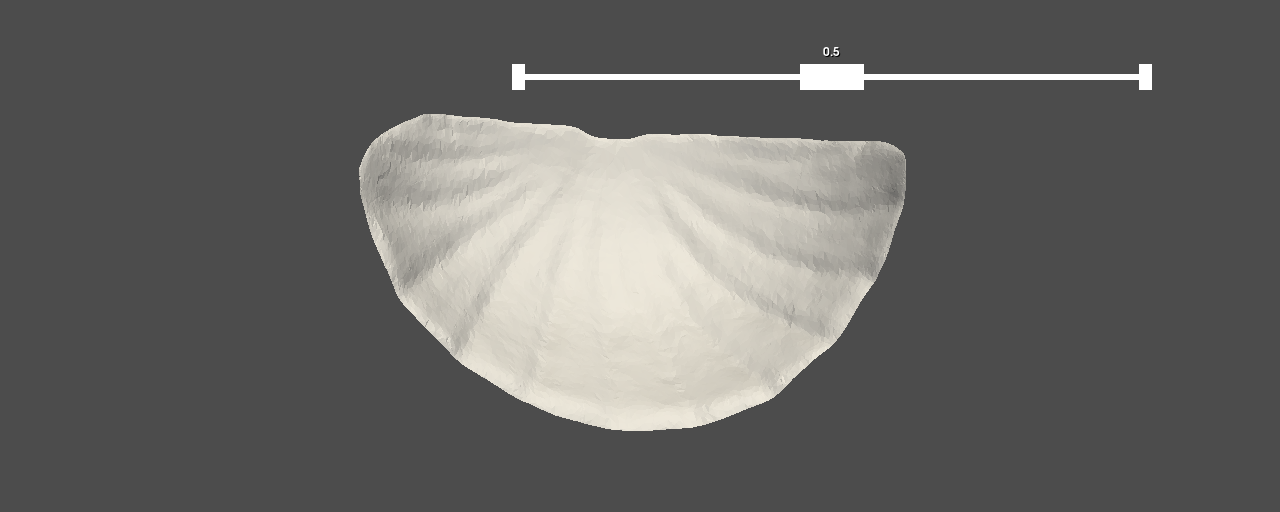

In [46]:
# visualize
update_mesh = lambda t: pl.update_coordinates(np.array(M.from_coords(gam_g.eval(t))))

pl = pv.Plotter(notebook=True)
mesh = pv.PolyData(np.array(M.from_coords(gam_g.eval(0.))), np.array(pyT.faces))
pl.add_mesh(mesh)
pl.view_xz()
pl.camera.zoom(1.3)
slider = pl.add_slider_widget(callback=update_mesh, rng=(0, 1), pointa=(0.4, .85), pointb=(0.9, .85), )
pl.show(jupyter_backend='trame', window_size=(1280,512))

Here is the Roman trend.

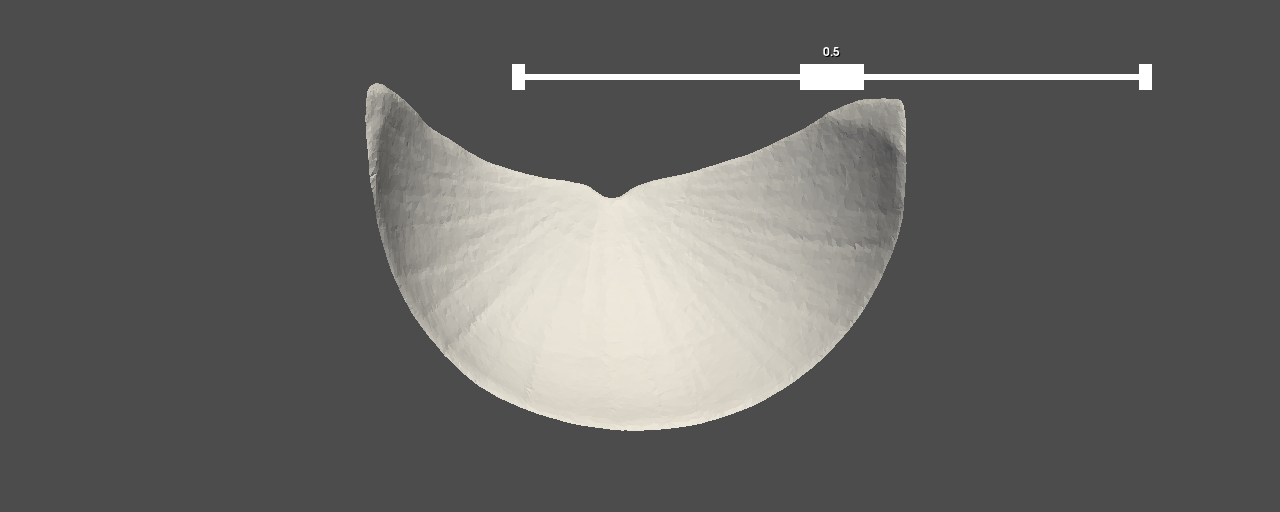

In [47]:
# visualize
update_mesh = lambda t: pl.update_coordinates(np.array(M.from_coords(gam_r.eval(t))))

pl = pv.Plotter(notebook=True)
mesh = pv.PolyData(np.array(M.from_coords(gam_r.eval(0.))), pyT.faces)
pl.add_mesh(mesh)
pl.view_xz()
pl.camera.zoom(1.3)
slider = pl.add_slider_widget(callback=update_mesh, rng=(0, 1), pointa=(0.4, .85), pointb=(0.9, .85), )
pl.show(jupyter_backend='trame', window_size=(1280,512))

Now, we define the normalization for each set as detailed in the paper.

In [7]:
def normalized_mean_g(lat):
    lat_norm = (lat - jnp.min(lat_g)) / (jnp.max(lat_g) - jnp.min(lat_g))
    # point differences will be transported to
    base = M.exp(gam_g.control_points[0][0], lat_norm * M.log(gam_g.control_points[0][0], gam_g.control_points[0][1]))

    # transport difference vectors and shoot
    surf = []
    for k, tt in enumerate(t_g):
        X = M.log(gam_g.eval(tt), C_g[k])
        X = M.transp(gam_g.eval(tt), base, X)
        p = M.exp(base, X)
        # get (centered and scaled) mesh back
        v = preshape(M.from_coords(p))

        S = Surface(v, f)
        surf.append(S)

    # compute the mean
    SSM = StatisticalShapeModel(lambda ref: DifferentialCoords(ref))
    SSM.construct(surf)
    return SSM.mean.v

def normalized_mean_r(lat):
    lat_norm = (lat - jnp.min(lat_r)) / (jnp.max(lat_r) - jnp.min(lat_r))
    # point differences will be transported to
    base = M.exp(gam_r.control_points[0][0], lat_norm * M.log(gam_r.control_points[0][0], gam_r.control_points[0][1]))

    # transport difference vectors and shoot
    surf = []
    for k, tt in enumerate(t_r):
        X = M.log(gam_r.eval(tt), C_r[k])
        X = M.transp(gam_r.eval(tt), base, X)
        p = M.exp(base, X)
        # get (centered and scaled) mesh back
        v = preshape(M.from_coords(p))

        S = Surface(v, f)
        surf.append(S)

    # compute the mean
    SSM = StatisticalShapeModel(lambda ref: DifferentialCoords(ref))
    SSM.construct(surf)
    return SSM.mean.v

We can now normalize the shapes of each group at some latitude in the range provided by the data. We start with the Greek shadow surfaces and plot the mean of the normalized shapes. The latitude at which the normalization is performed is set between 36° and 38° since the sites of the data lie there.

0.0012691004
1.6617329e-05
1.1721265e-05
7.805767e-06
7.807266229065135e-06 > 7.805767381796613e-06 --> divergence
0.0012691004
1.6617329e-05
1.1721265e-05
7.805767e-06
7.807266229065135e-06 > 7.805767381796613e-06 --> divergence


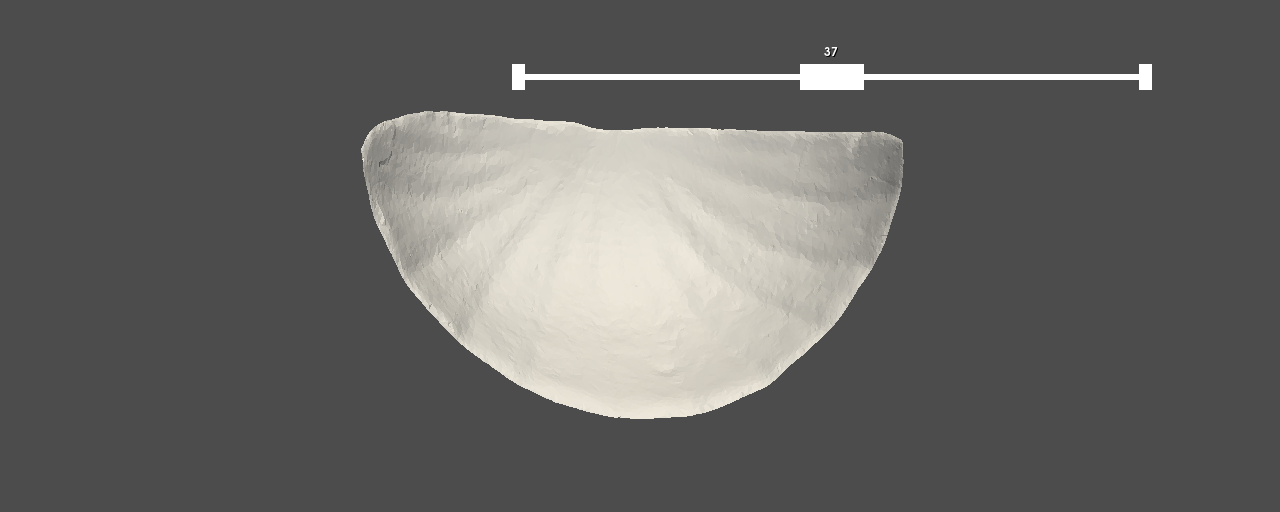

In [48]:
update_mesh = lambda l: pl.update_coordinates(np.array(normalized_mean_g(l)))

pl = pv.Plotter(notebook=True)
mesh = pv.PolyData(np.array(normalized_mean_g(37.)), pyT.faces)
pl.add_mesh(mesh)
pl.view_xz()
pl.camera.zoom(1.3)
slider = pl.add_slider_widget(callback=update_mesh, rng=(36, 38), pointa=(0.4, .85), pointb=(0.9, .85), )
pl.show(jupyter_backend='trame', window_size=(1280,512))

Finally, we can do the same for the Roman sundials. Their sites have latitudes ranging between 40° and 44°.

0.0021645427
3.02831e-05
2.4910718e-05
2.4154542e-05
2.4185983420466073e-05 > 2.4154542188625783e-05 --> divergence
0.0022624696
2.4318859e-05
1.8069679e-05
1.7400242e-05
1.7435841073165648e-05 > 1.7400241631548852e-05 --> divergence


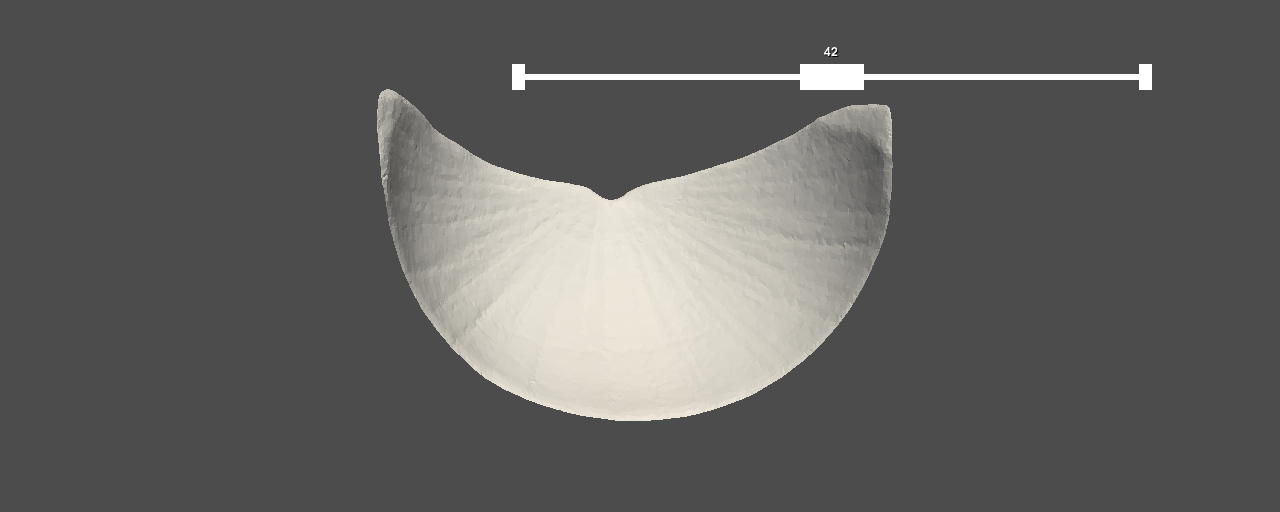

In [49]:
update_mesh = lambda l: pl.update_coordinates(np.array(normalized_mean_r(l)))

pl = pv.Plotter(notebook=True)
mesh = pv.PolyData(np.array(normalized_mean_r(41.)), pyT.faces)
pl.add_mesh(mesh)
pl.view_xz()
pl.camera.zoom(1.3)
slider = pl.add_slider_widget(callback=update_mesh, rng=(40, 44), pointa=(0.4, .85), pointb=(0.9, .85), )
pl.show(jupyter_backend='trame', window_size=(1280,512))